# Kaggle Competition:  Iceberg or Ship
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

## Notebook 1:  Set up data

In [1]:
!ls -l

total 1844
-rw-rw-r-- 1 ubuntu ubuntu 623462 Jan 14 18:36 1_getdata.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 245619 Jan 14 18:36 2_model_resnet34.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  13445 Jan 14 18:36 3_model_resnext50.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  14220 Jan 13 21:14 4_model_nasnet.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  64965 Jan 14 18:36 4_resnext_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 137540 Jan 14 18:36 baseline.ipynb
-rw-rw-r-- 1 ubuntu ubuntu    536 Jan 14 18:36 helper.py
-rw-rw-r-- 1 ubuntu ubuntu 767392 Jan 14 18:36 other_groverpr.ipynb
-rw-rw-r-- 1 ubuntu ubuntu    185 Jan  8 22:18 README.md


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# update `.bashrc` file 
#import sys
#sys.path.insert(0,'/home/nidhin/fastai')

#export PYTHONPATH=$PYTHONPATH:/home/nidhin/fastai


In [4]:
from fastai.imports import *

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
import shutil
from IPython.display import FileLink, FileLinks

from sklearn.model_selection import train_test_split


In [6]:
#!ls /home/nidhin/data/iceberg
!ls -l /home/ubuntu/data/iceberg

total 1973260
drwxrwxr-x  2 ubuntu ubuntu       4096 Jan  9 00:38 models
-rw-rw-r--  1 ubuntu ubuntu     117951 Oct 23 17:27 sample_submission.csv
-rw-rw-r--  1 ubuntu ubuntu      38566 Jan  7 20:36 sample_submission.csv.7z
drwxrwxr-x  2 ubuntu ubuntu     274432 Jan  8 21:46 test
-rw-rw-r--  1 ubuntu ubuntu 1521771850 Oct 23 17:27 test.json
-rw-rw-r--  1 ubuntu ubuntu  257127394 Jan  7 20:36 test.json.7z
drwxrwxr-x 44 ubuntu ubuntu       4096 Jan 13 23:25 tmp
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan  8 21:45 train
-rw-rw-r--  1 ubuntu ubuntu  196313674 Oct 23 17:23 train.json
-rw-rw-r--  1 ubuntu ubuntu   44932785 Jan  7 20:36 train.json.7z
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan  8 21:45 valid


In [7]:
#PATH = "/home/nidhin/data/iceberg/"
PATH = os.path.expanduser("~/data/iceberg/")

In [8]:
!ls -l {PATH}

total 1973260
drwxrwxr-x  2 ubuntu ubuntu       4096 Jan  9 00:38 models
-rw-rw-r--  1 ubuntu ubuntu     117951 Oct 23 17:27 sample_submission.csv
-rw-rw-r--  1 ubuntu ubuntu      38566 Jan  7 20:36 sample_submission.csv.7z
drwxrwxr-x  2 ubuntu ubuntu     274432 Jan  8 21:46 test
-rw-rw-r--  1 ubuntu ubuntu 1521771850 Oct 23 17:27 test.json
-rw-rw-r--  1 ubuntu ubuntu  257127394 Jan  7 20:36 test.json.7z
drwxrwxr-x 44 ubuntu ubuntu       4096 Jan 13 23:25 tmp
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan  8 21:45 train
-rw-rw-r--  1 ubuntu ubuntu  196313674 Oct 23 17:23 train.json
-rw-rw-r--  1 ubuntu ubuntu   44932785 Jan  7 20:36 train.json.7z
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan  8 21:45 valid


In [9]:
class_map = {1:'ice',0:'ship'}

In [10]:
train_df = pd.read_json(PATH+"/train.json")
train_df['classes'] = train_df['is_iceberg'].map(class_map)

test_df = pd.read_json(PATH+"/test.json")


In [11]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg,classes
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,ship
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,ship
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,ice
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,ship
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,ship


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, train_df['is_iceberg'], test_size=0.20, random_state=42)

In [13]:
def normalize_band(band):
    normalized_band = (band-np.min(band))/(np.max(band)-np.min(band))
    
    band = np.array(normalized_band).reshape((75, 75))
    pband = band - np.mean(band)
    pband[pband < band.std() * 2] = 0
    pband = np.mean(np.abs(np.gradient(pband)),axis=0)
    return pband
    
    #positive = band + np.amin(band)
    #normalized = positive / np.amax(positive)
    
    #return normalized
    
    #return band

    
def color_composite(band):
    band = np.array(band)
    band = band.reshape(75, 75)
    
    modified_band = (band + abs(band.min())) / np.max((band + abs(band.min())))
    
    return modified_band
    
def scale_image(row):
    band_1 = color_composite(row['band_1'])
    band_2 = color_composite(row['band_2'])
        
    #band_3 = normalize_band(band_1 + band_2)
    band_3 = color_composite(band_1/band_2)

    return np.dstack((band_1, band_2, band_3))
    
def get_scaled_imgs(df):
    imgs = []
    for i, row in df.iterrows():
        
        imgs.append ( scale_image(row)) 

    return np.array(imgs)



In [14]:
X_all = get_scaled_imgs(train_df.head(10))
#test_all = get_scaled_imgs(test_df)
y_all = train_df['is_iceberg'].head(10)
y_classes = train_df['classes'].head(10)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


## View images

In [15]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

Band 1


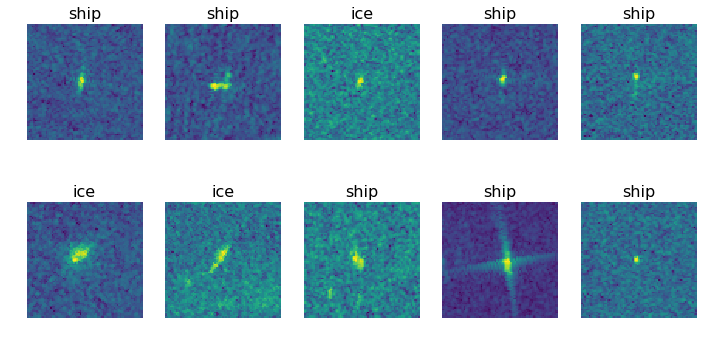

In [16]:
print("Band 1")
plots(X_all[:,:,:,0],rows=2, titles=y_classes)

Band 2


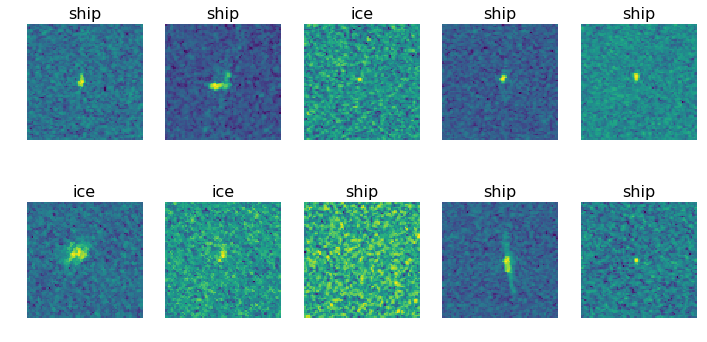

In [17]:
print("Band 2")
plots(X_all[:,:,:,1],rows=2, titles=y_classes)

Band 3


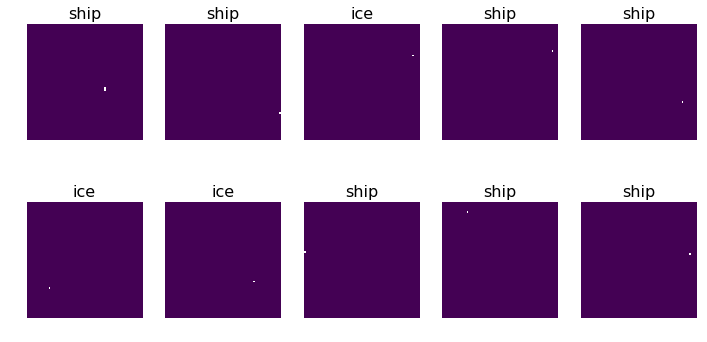

In [18]:
print("Band 3")
plots(X_all[:,:,:,2],rows=2, titles=y_classes)

All Bands


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


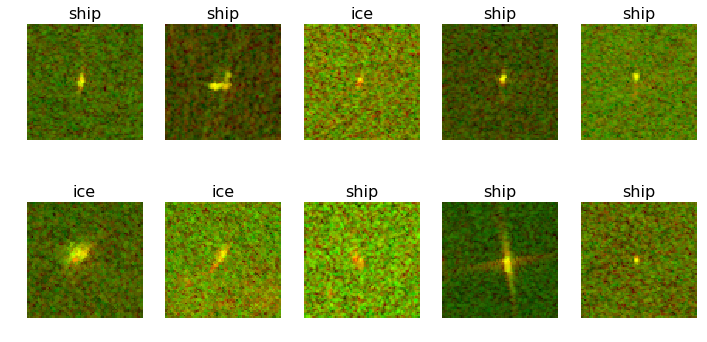

In [19]:
print("All Bands")
plots(X_all[:,:,:],rows=2, titles=y_classes)

In [20]:
# see breakdown of classes in training dataset
train_df['is_iceberg'].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [21]:
# get percents
train_df['is_iceberg'].value_counts(normalize=True)

0    0.530549
1    0.469451
Name: is_iceberg, dtype: float64

## Separate out Train / Test data

In [22]:
for img_class in class_map.values():
    shutil.rmtree(f"{PATH}train/{img_class}",ignore_errors=True)
    os.makedirs(f"{PATH}train/{img_class}")

    shutil.rmtree(f"{PATH}valid/{img_class}",ignore_errors=True)
    os.makedirs(f"{PATH}valid/{img_class}")
    
    shutil.rmtree(f"{PATH}test",ignore_errors=True)
    os.makedirs(f"{PATH}test")
        

def save_images(images_df,folder):
    print (f"Saving {folder}")
    if "classes" in images_df:
        for _,img_row in images_df.iterrows():
            label = img_row['classes']
            normalized_img = scale_image(img_row)
            img_id = img_row["id"]
            plt.imsave(f"{PATH}{folder}/{label}/{img_id}.jpeg",normalized_img)
    else:
        # only for test
        for _,img_row in images_df.iterrows():
            normalized_img = scale_image(img_row)
            img_id = img_row["id"]
            plt.imsave(f"{PATH}{folder}/{img_id}.jpeg",normalized_img)
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [23]:
X_train.head()

,band_1,band_2,id,inc_angle,is_iceberg,classes
705,"[-1.344282, -1.344282, 0.9948239999999999, -2....","[-14.172397, -14.172397, -10.502144, -14.02402...",fd47c6f9,39.2166,1,ice
962,"[-24.817394, -25.328541, -25.328602, -24.57289...","[-22.634506000000002, -21.719418, -22.443724, ...",94462587,37.254,1,ice
599,"[-14.993799, -16.242653, -18.952848, -21.65787...","[-22.353334, -20.709526, -24.156723, -23.93674...",ec822cf5,34.1486,0,ship
411,"[-19.098007, -17.286678, -15.369007, -16.50553...","[-27.575521, -27.575588, -26.04789, -24.0539, ...",e2a547bf,35.2994,1,ice
710,"[-16.564709, -17.085022, -17.988312, -17.30227...","[-28.406221, -28.810337, -31.172371, -27.65059...",49f4d394,41.8505,0,ship


In [24]:
save_images(X_train,"train")
save_images(X_valid,"valid")
save_images(test_df,"test")


Saving train


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Saving valid
Saving test


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [30]:
# print number of files in each folder
print("training data - ship")
!ls -l {PATH}train/ship | grep ^[^d] | wc -l

print("training data - ice")
!ls -l {PATH}train/ice | grep ^[^d] | wc -l

print("validation data - ship")
!ls -l {PATH}valid/ship | grep ^[^d] | wc -l

print("validation data - ice")
!ls -l {PATH}valid/ice | grep ^[^d] | wc -l

print("test data")
!ls -l {PATH}test | grep ^[^d] | wc -l

training data - ship
695
training data - ice
590
validation data - ship
158
validation data - ice
165
test data
8425


---